In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Import function to create training and test set splits
from sklearn.model_selection import train_test_split
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import sqrt
import csv

In [2]:
df = pd.read_csv('../temp_data/histData.csv')

In [40]:
from pykalman import KalmanFilter

## Delta and Drift

In [32]:
delta = (df.close - df.close.shift(1)) * 10000

In [33]:
drift = delta.rolling(window=480).sum()

In [34]:
drift_norm = (drift - drift.rolling(window=480).mean()) / drift.rolling(window=480).std()

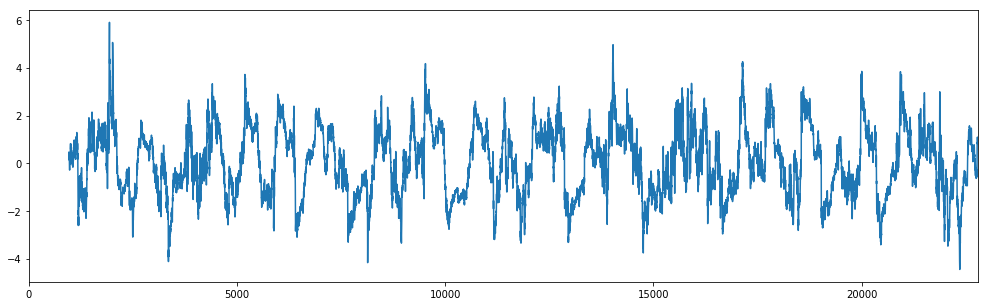

In [35]:
drift_norm.plot(figsize=(17,5));

In [36]:
drift_norm2 = drift_norm.dropna()
drift2 = drift.dropna()

In [37]:
print(drift2[:5])
# prepare data for standardization
values = drift2.values
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
	print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
	print(inversed[i])

480   -170.25
481   -169.50
482   -167.50
483   -167.50
484   -172.75
Name: close, dtype: float64
Mean: -4.464540, StandardDeviation: 66.452793
[-2.49478542]
[-2.48349921]
[-2.45340266]
[-2.45340266]
[-2.53240611]
[-170.25]
[-169.5]
[-167.5]
[-167.5]
[-172.75]


In [38]:
len(normalized)

22307

In [39]:
dfn1 = df.assign(drift= drift)

In [40]:
dfn2 = dfn1.dropna()

In [41]:
dfn3 = dfn2.assign(norm_drift = normalized)

In [42]:
norm_drift_ahead = dfn3.norm_drift.shift(-480)

In [43]:
dfn4 = dfn3.assign(norm_drift_ahead = norm_drift_ahead)

In [44]:
dfn5 = dfn4.dropna()

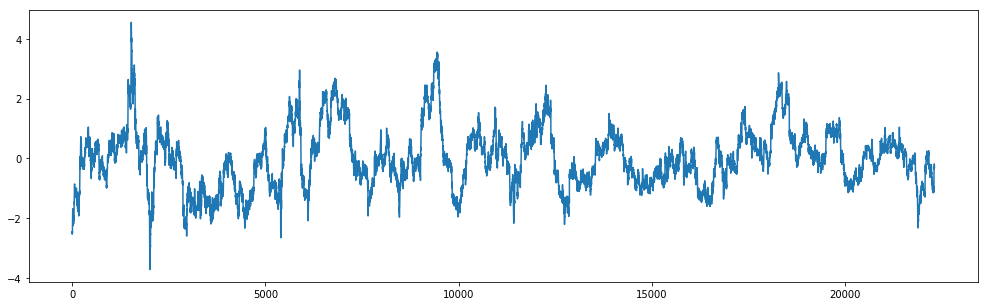

In [45]:
plt.figure(figsize=(17,5))
plt.plot(normalized);

## Volatility

In [46]:
highLow = (df.high - df.low) * 10000

In [47]:
vol = highLow.rolling(window=480).mean()

In [48]:
vol_norm= (vol - vol.rolling(window=480).mean()) / vol.rolling(window=480).std()

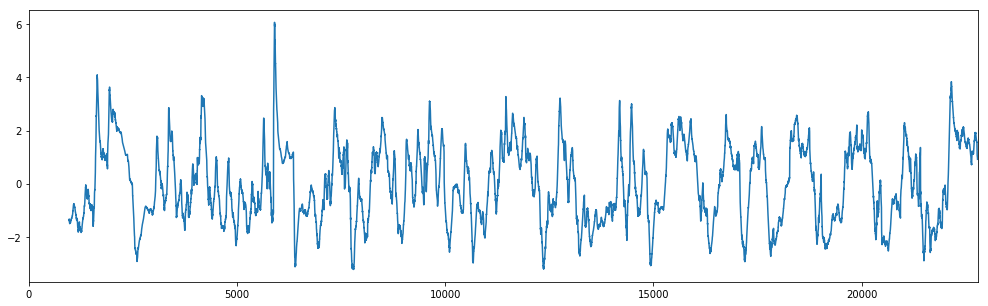

In [49]:
vol_norm.plot(figsize=(17,5));

#### Adding Features in the DataFrame

In [50]:
df1 = df.assign(vol_norm = vol_norm)
df2 = df1.assign(drift_norm = drift_norm)

#### Shifting values ahead

In [51]:
drift_norm_ahead = drift_norm.shift(-480)
vol_norm_ahead = vol_norm.shift(-480)

In [52]:
df3 = df2.assign(drift_norm_ahead = drift_norm_ahead)
df4 = df3.assign(vol_norm_ahead = vol_norm_ahead)

In [53]:
df5 = df4.dropna()

In [54]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[df5.drift_norm_ahead], [np.ones(len(df5.drift_norm))]]).T, axis=1)

In [55]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

NameError: name 'KalmanFilter' is not defined

In [56]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(df5.drift_norm_ahead.values)

NameError: name 'kf' is not defined

Text(0,0.5,'Drift_Norm')

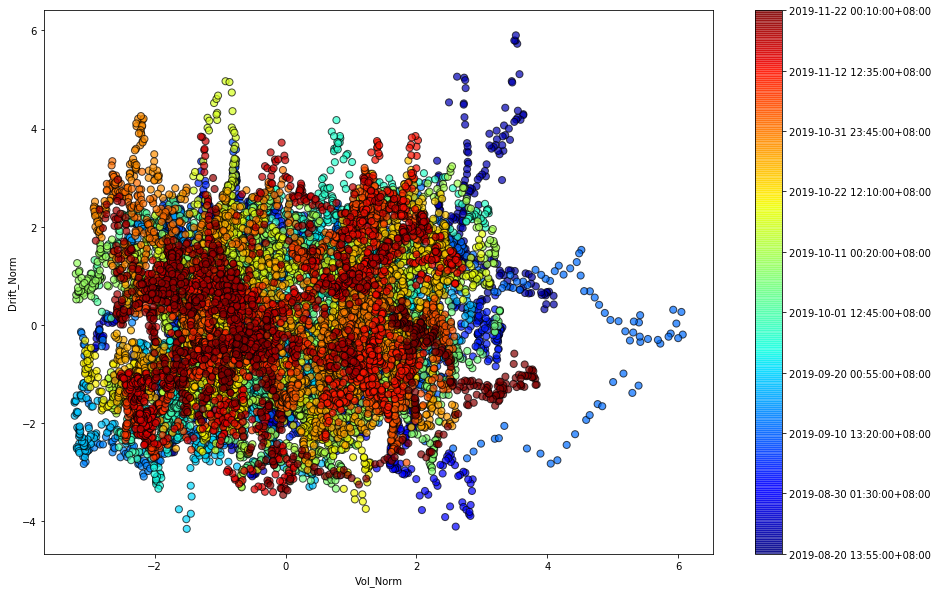

In [75]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df5['date'][::len(df5['date'])//10]]
colors = np.linspace(0.1, 1, len(df5))
sc = plt.scatter(df5.vol_norm, df5.drift_norm, s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df5['date'][::len(df5['date'])//10]]);
plt.xlabel('Vol_Norm')
plt.ylabel('Drift_Norm')

# # add regression lines
# step = 5
# xi = np.linspace(df5.drift_norm.min(), df5.drift_norm.max(), 2)
# colors_l = np.linspace(0.1, 1, len(state_means[::step]))
# for i, beta in enumerate(state_means[::step]):
#     plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

Text(0,0.5,'Drift_Norm')

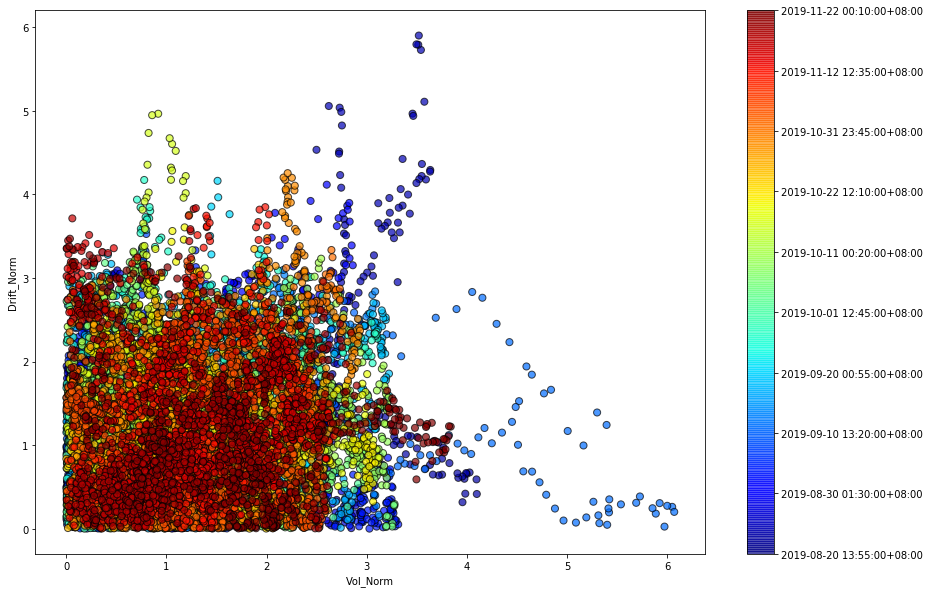

In [76]:
# visualize the correlation between assest prices over time
fig = plt.figure(figsize=(15,10));
cm = plt.cm.get_cmap('jet')
dates = [p for p in df5['date'][::len(df5['date'])//10]]
colors = np.linspace(0.1, 1, len(df5))
sc = plt.scatter(abs(df5.vol_norm), abs(df5.drift_norm), s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in df5['date'][::len(df5['date'])//10]]);
plt.xlabel('Vol_Norm')
plt.ylabel('Drift_Norm')

In [58]:
rho1 = df5['drift_norm_ahead'].rolling(window=960).corr(df5['drift_norm'])

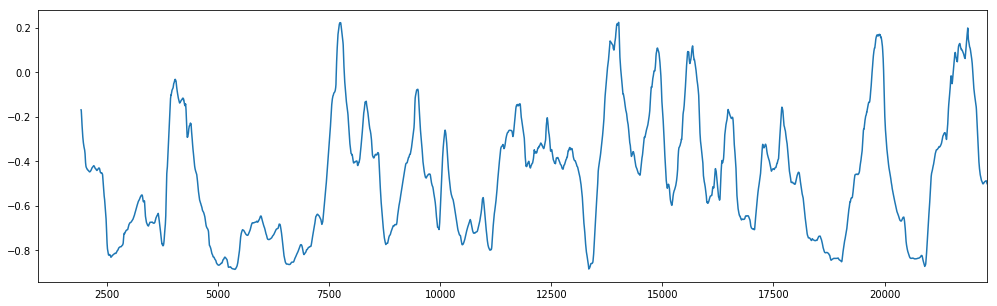

In [59]:
rho1.plot(figsize=(17,5));

In [70]:
from itertools import chain

class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" %
                               str(options))
            
#         if ((self.target==None )|(self.date_col==None )|
#             (self.date_init==None )|(self.date_final==None )):
             
#              raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")
            
            for i in range(self.date_init,self.date_final):
                
                train = X[X[self.date_col] < i]
                val   = X[X[self.date_col] == i]
                
                X_train, X_test = train.drop([self.target], axis=1),val.drop([self.target], axis=1)
                
                y_train, y_test = train[self.target].values,val[self.target].values
                
                yield X_train, X_test, y_train, y_test
            
        def split(self,X):
            cv_t = self._train_test_split_time(X)
            return chain(cv_t)

In [71]:
kf = Kfold_time(target=df5['drift_norm_ahead'], date_col=df5['date'], date_init='2019-11-15', date_final='2019-11-30')

In [73]:
#%%
'''
Expanding window cross validation
Similar to sklearn format
@ germayne  
'''
import numpy as np

class expanding_window(object):
    '''	
    Parameters 
    ----------
    
    Note that if you define a horizon that is too far, then subsequently the split will ignore horizon length 
    such that there is validation data left. This similar to Prof Rob hyndman's TsCv 
    
    
    initial: int
        initial train length 
    horizon: int 
        forecast horizon (forecast length). Default = 1
    period: int 
        length of train data to add each iteration 
    '''
    

    def __init__(self,initial= 1,horizon = 1,period = 1):
        self.initial = initial
        self.horizon = horizon 
        self.period = period 


    def split(self,data):
        '''
        Parameters 
        ----------
        
        Data: Training data 
        
        Returns 
        -------
        train_index ,test_index: 
            index for train and valid set similar to sklearn model selection
        '''
        self.data = data
        self.counter = 0 # for us to iterate and track later 


        data_length = data.shape[0] # rows 
        data_index = list(np.arange(data_length))
         
        output_train = []
        output_test = []
        # append initial 
        output_train.append(list(np.arange(self.initial)))
        progress = [x for x in data_index if x not in list(np.arange(self.initial)) ] # indexes left to append to train 
        output_test.append([x for x in data_index if x not in output_train[self.counter]][:self.horizon] )
        # clip initial indexes from progress since that is what we are left 
         
        while len(progress) != 0:
            temp = progress[:self.period]
            to_add = output_train[self.counter] + temp
            # update the train index 
            output_train.append(to_add)
            # increment counter 
            self.counter +=1 
            # then we update the test index 
            
            to_add_test = [x for x in data_index if x not in output_train[self.counter] ][:self.horizon]
            output_test.append(to_add_test)

            # update progress 
            progress = [x for x in data_index if x not in output_train[self.counter]]	
            
        # clip the last element of output_train and output_test
        output_train = output_train[:-1]
        output_test = output_test[:-1]
        
        # mimic sklearn output 
        index_output = [(train,test) for train,test in zip(output_train,output_test)]
        
        return index_output
        
        
#%%
#%%


In [74]:
# demo 

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])

y = np.array([1, 2, 3, 4, 5, 6])
tscv = expanding_window()
for train_index, test_index in tscv.split(X):
    print(train_index)
    print(test_index)



X = np.random.randint(0,1000,size = (120,2))
y = np.random.randint(0,1000,size = (120,1))

tscv = expanding_window(initial = 36, horizon = 24,period = 1)
for train_index, test_index in tscv.split(X):
    print(train_index)
    print(test_index)

[0]
[1]
[0, 1]
[2]
[0, 1, 2]
[3]
[0, 1, 2, 3]
[4]
[0, 1, 2, 3, 4]
[5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57

In [72]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(np.array(df5[['drift_norm', 'vol_norm']]).reshape(-1,2),
                                                    np.array(df5['drift_norm_ahead']),test_size=0.3)

degreeHolder = []
rmseHolder = []
scoreHolder = []
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=kf))
    degreeHolder.append(degree)
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    rmseHolder.append(RMSE)
    test_score = model.score(X_test,y_test)
    scoreHolder.append(test_score)
    
    # to save the model
    pkl_filename = "models/model_"+str(degree)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

ValueError: Expected cv as an integer, cross-validation object (from sklearn.model_selection) or an iterable. Got <__main__.Kfold_time object at 0x000001C9A2F228D0>.

In [61]:
outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})
outputDF

,degree,rmse,r2
0,2,101.243906,0.198203
1,3,100.890962,0.203783
2,4,100.772955,0.205645
3,5,100.600885,0.208355
4,6,100.471382,0.210392
5,7,100.295327,0.213157
6,8,100.198443,0.214676


In [63]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(np.array(dfn5[['norm_drift']]).reshape(-1,1),
                                                    np.array(dfn5['norm_drift_ahead']),test_size=0.3)

degreeHolder = []
rmseHolder = []
scoreHolder = []
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    degreeHolder.append(degree)
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    rmseHolder.append(RMSE)
    test_score = model.score(X_test,y_test)
    scoreHolder.append(test_score)
    
    # to save the model
    pkl_filename = "models/model_"+str(degree)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

In [64]:
outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})
outputDF

,degree,rmse,r2
0,2,80.129625,0.022722
1,3,79.977685,0.026424
2,4,79.972166,0.026559
3,5,79.875598,0.028908
4,6,79.864160,0.029186
5,7,79.758463,0.031754
6,8,79.759936,0.031718


In [24]:
def get_drift_norm(dataframe):
    
    window = 480
    
    df0 = dataframe
    # calculate delta
    delta = (df0.close - df0.close.shift(1)) * 10000
    # calculate drift
    drift = delta.rolling(window=window).sum()
    # normalize drift
    drift_norm = (drift - drift.rolling(window=window).mean()) / drift.rolling(window=window).std()
    # add it into the dataframe
    df1 = df0.assign(drift_norm = drift_norm)
    # return the dataframe
    return df1
    

In [25]:
def get_vol_norm(dataframe):
    
    window = 480
    
    df0 = dataframe
    # calculate the true range
    highLow = (df0.high - df0.low) * 10000
    # calculate the volatility
    vol = highLow.rolling(window=window).mean()
    # normalize the volatility
    vol_norm= (vol - vol.rolling(window=window).mean()) / vol.rolling(window=window).std()
    # add it into the dataframe
    df1 = df0.assign(vol_norm = vol_norm)
    # return the dataframe
    return df1

In [26]:
def get_ahead_data(dataframe):
    
    window = 480
    
    df0 = dataframe
    # shifting ahead series
    drift_norm_ahead = drift_norm.shift(-window)
    vol_norm_ahead = vol_norm.shift(-window)
    # add it into the dataframe
    df1 = df0.assign(drift_norm_ahead = drift_norm_ahead)
    df2 = df1.assign(vol_norm_ahead = vol_norm_ahead)
    # return the dataframe
    return df2

In [27]:
def clean_data(dataframe):
    
    df0 = dataframe
    # dropna
    df1 = df0.dropna()
    # return the dataframe
    return df1

In [28]:
def train_model(dataframe):
    
    df0 = dataframe
    
    # Alpha (regularization strength) of LASSO regression
    lasso_eps = 0.0001
    lasso_nalpha=20
    lasso_iter=5000

    # Min and max degree of polynomials features to consider
    degree_min = 2
    degree_max = 8

    # Test/train split
    X_train, X_test, y_train, y_test = train_test_split(np.array(df0[['drift_norm', 'vol_norm']]).reshape(-1,2),
                                                        np.array(df0['drift_norm_ahead']),test_size=0.3)

    degreeHolder = []
    rmseHolder = []
    scoreHolder = []
    # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
    for degree in range(degree_min,degree_max+1):
        model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
    normalize=True,cv=5))
        degreeHolder.append(degree)
        model.fit(X_train,y_train)
        test_pred = np.array(model.predict(X_test))
        RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
        rmseHolder.append(RMSE)
        test_score = model.score(X_test,y_test)
        scoreHolder.append(test_score)
        #print(test_score)

        # to save the model
        pkl_filename = "models/model_"+str(degree)+".pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(model, file)
            
    outputDF = pd.DataFrame({'degree': degreeHolder, 'rmse': rmseHolder, 'r2':scoreHolder})
    # return dataframe
    return outputDF

In [29]:
def run_train():
    
    fileName = 'train_data.csv'
    df0 = pd.read_csv(fileName)
    # get normalized drift
    df1 = get_drift_norm(df0)
    # get normalized volatility
    df2 = get_vol_norm(df1)
    # get ahead values
    df3 = get_ahead_data(df2)
    # clean data
    df4 = clean_data(df3)
    # train model
    result = train_model(df4)
    # print result
    #print(result)
    return result

In [116]:
result = run_train()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [117]:
result

,degree,rmse,r2
0,2,68.501834,0.255796
1,3,67.171791,0.284414
2,4,66.710916,0.294200
3,5,66.424944,0.300238
4,6,66.037131,0.308385
5,7,65.878780,0.311698
6,8,65.651979,0.316429


In [118]:
def load_model():
    
    # load from file
    with open('models/model_8.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model

In [119]:
def get_prediction(dataframe, loaded_model):
    
    df0 = dataframe
    # reshape features in an array
    X = np.array(df0[['drift_norm', 'vol_norm']]).reshape(-1,2)
    # predict from the model
    y_predict = loaded_model.predict(X) 
    # place prediction in the dataframe
    df1 = df0.assign(predict = y_predict)
    # return dataframe
    return df1

In [93]:
def run_model():
    
    fileName = '../temp_data/histData.csv'
    df0 = pd.read_csv(fileName)
    # get normalized drift
    df1 = get_drift_norm(df0)
    # get normalized volatility
    df2 = get_vol_norm(df1)
    # clean data
    df3 = clean_data(df2)
    # load model
    loaded_model = load_model()
    # get prediction
    df4 = get_prediction(df3, loaded_model)
    # save prediction
    df4.to_csv('new_data.csv')

In [94]:
run_model()

In [95]:
test = pd.read_csv('new_data.csv')

In [96]:
test.predict.describe()

count    21828.000000
mean         0.055670
std          0.668969
min         -3.279532
25%         -0.393505
50%          0.164018
75%          0.569129
max          6.511896
Name: predict, dtype: float64

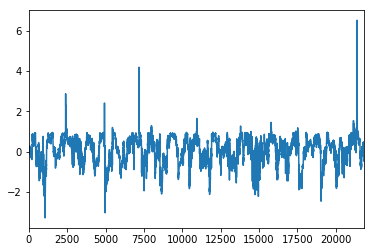

In [97]:
test.predict.plot()

In [113]:
def split_data():
    
    fileName = '../temp_data/histData.csv'
    df0 = pd.read_csv(fileName)
    
    length = len(df0)
    half_length = int(length / 2)
    
    df1 = df0.iloc[:half_length]
    df1.to_csv('train_data.csv')
    
    df2 = df0.iloc[half_length:]
    df2.to_csv('validate_data.csv')

In [114]:
split_data()

In [120]:
def evaluate_performance(dataframe, loaded_model):
    
    df0 = dataframe
    
    rmseHolder = []
    scoreHolder = []
    
    RMSE=np.sqrt(np.sum(np.square(df0.predict - df0.drift_norm_ahead)))
    rmseHolder.append(RMSE)
    test_score = loaded_model.score(np.array(df0[['drift_norm', 'vol_norm']]).reshape(-1,2) ,
                                    np.array(df0['drift_norm_ahead']))
    scoreHolder.append(test_score)
    
    outputDF = pd.DataFrame({'rmse': rmseHolder, 'r2':scoreHolder})
    
    return outputDF

In [123]:
def validate_model():
    
    fileName = '../temp_data/histData.csv'
    df0 = pd.read_csv(fileName)
    # get normalized drift
    df1 = get_drift_norm(df0)
    # get normalized volatility
    df2 = get_vol_norm(df1)
    # get ahead values
    df3 = get_ahead_data(df2)
    # clean data
    df4 = clean_data(df3)
    # load model
    loaded_model = load_model()
    # get prediction
    df5 = get_prediction(df4, loaded_model)
    # evaluate performance
    df6 = evaluate_performance(df5, loaded_model)
    # print result
    print(df6)
    

In [124]:
validate_model()

         rmse        r2
0  208.464186 -0.033589


In [125]:
test.iloc[-1]

Unnamed: 0                        22786
date          2019-12-05 04:50:00+08:00
open                             1.6168
high                            1.61695
low                             1.61675
close                            1.6168
volume                               -1
drift_norm                     0.885295
vol_norm                       0.919307
predict                       -0.297431
Name: 21827, dtype: object

In [131]:
def save_prediction(dataframe):
    print("at save prediction")
    #latestBar = [pd.to_datetime(bars01[-1].time).tz_convert("Asia/Hong_Kong"), bars01[-1].open_, bars01[-1].high,
    #             bars01[-1].low, bars01[-1].close, bars01[-1].volume]
    df0 = dataframe             
    latestBar = [df0.date.iloc[-1], df0.predict.iloc[-1]]
    print(latestBar)
    
    # write datapoints in csv file
    with open('C:/Users/Yousuf/Downloads/SixLynx/Lynx1/temp_data/predict_data.csv', 'a') as csvFile:
       writer = csv.writer(csvFile)
       writer.writerow(latestBar)
    csvFile.close()
    # this can be optimized
    latestDf = pd.DataFrame([latestBar], columns=['date', 'predict'])
    #latestDf.to_sql(mkt_table, conn, if_exists='replace')
    return latestDf['date'].iloc[0]

In [132]:
save_prediction(test)

at save prediction
['2019-12-05 04:50:00+08:00', -0.2974307700252662]


'2019-12-05 04:50:00+08:00'